In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
import torch
import tensorflow as tf
from transformers import pipeline
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments
from transformers import DistilBertTokenizerFast
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification

In [2]:
music_data=pd.read_csv('Music_ml_data.csv')
music_data.head()

,overall,asin,unixReviewTime,overall_split,date,text,text_token,positive,negative,neutral,compound,vader_sentiment
0,2,B002MQ7JOU,1253750400,1.0,2009-09-24,second love by collin obremski mostly this abu...,"['second', 'love', 'collin', 'obremski', 'most...",0.318,0.179,0.503,0.9975,Positive
1,2,B00136PP8M,1441065600,1.0,2015-09-01,i thought this was going to be the arrangement...,"['thought', 'going', 'arrangement', 'remember'...",0.117,0.061,0.821,0.3976,Neutral
2,5,B0161BPHKY,1484697600,0.0,2017-01-18,love the song it speaks how we should teach ou...,"['love', 'song', 'speaks', 'teach', 'child', '...",0.277,0.000,0.723,0.7845,Positive
3,5,B007XXFHLO,1410134400,0.0,2014-09-08,jesus is the name of our savior i love it,"['jesus', 'name', 'savior', 'love']",0.344,0.000,0.656,0.6369,Positive
4,5,B00BJ9RNE2,1505260800,0.0,2017-09-13,this was recommended by my psychologist to rel...,"['recommended', 'psychologist', 'relax', 'def'...",0.318,0.000,0.682,0.8658,Positive


In [3]:
music_data['vader_sentiment'].value_counts()

Positive    24804
Neutral      8639
Negative     3393
Conflict     3164
Name: vader_sentiment, dtype: int64

In [4]:
label_encoder=LabelEncoder()
music_data['sentiment_encoded']=label_encoder.fit_transform(music_data['vader_sentiment'])

In [5]:
music_vector=pd.read_csv("music_vectorized.csv")
music_vector.head(2)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.006341,-0.048968,0.050782,0.004770,0.014288,-0.054868,-0.042598,-0.005151,-0.006990,0.062035,...,-0.004214,0.015523,0.008789,0.044980,-0.013625,-0.009514,0.099590,-0.044852,-0.035846,0.017131
1,-0.016574,-0.014582,0.004706,-0.057177,0.027480,-0.067841,-0.070344,0.090828,0.025527,-0.043992,...,-0.005843,0.024512,0.043574,0.020036,-0.071452,0.008643,0.052097,-0.027362,-0.052158,-0.024019


In [6]:
music_vector['sentiment_encoded']=music_data['sentiment_encoded']
music_vector.head(2)

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,sentiment_encoded
0,0.006341,-0.048968,0.050782,0.004770,0.014288,-0.054868,-0.042598,-0.005151,-0.006990,0.062035,...,0.015523,0.008789,0.044980,-0.013625,-0.009514,0.099590,-0.044852,-0.035846,0.017131,3
1,-0.016574,-0.014582,0.004706,-0.057177,0.027480,-0.067841,-0.070344,0.090828,0.025527,-0.043992,...,0.024512,0.043574,0.020036,-0.071452,0.008643,0.052097,-0.027362,-0.052158,-0.024019,2


In [7]:
music1=music_vector.loc[music_vector['sentiment_encoded']==0]
music1.shape

(3164, 769)

In [8]:
music2=music_vector.loc[music_vector['sentiment_encoded']==1]
music2.shape

(3393, 769)

In [9]:
music3=music_vector.loc[music_vector['sentiment_encoded']==2]
music3.shape

(8639, 769)

In [10]:
music4=music_vector.loc[music_vector['sentiment_encoded']==3]
music4.shape

(24804, 769)

In [11]:
music4=music4.sample(n=24800)
music4.shape

(24800, 769)

In [12]:
music3=music3.sample(n=24800,replace=True)
music3.shape

(24800, 769)

In [13]:
music2=music2.sample(n=24800,replace=True)
music2.shape

(24800, 769)

In [14]:
music1=music1.sample(n=24800,replace=True)
music1.shape

(24800, 769)

In [15]:
music_blc=pd.concat([music1,music2,music3,music4])
music_blc.shape

(99200, 769)

In [16]:
music_blc['sentiment_encoded'].value_counts()

0    24800
1    24800
2    24800
3    24800
Name: sentiment_encoded, dtype: int64

In [17]:
x=music_blc.drop('sentiment_encoded',axis=1)
y=music_blc['sentiment_encoded']

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state = 0)

In [24]:
def one_vs_rest(input_model,x_train,x_test,y_train,y_test):
    model=OneVsRestClassifier(input_model)
    model.fit(x_train,y_train)
    y_pred=model.predict(x_test)
    f1=f1_score(y_test,y_pred,average='weighted')
    accuracy=accuracy_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred,average='weighted')
    recall=recall_score(y_test,y_pred,average='weighted')
    cmat=confusion_matrix(y_test,y_pred)
    report=classification_report(y_test,y_pred)
    return(model,y_pred,f1,accuracy,precision,recall,cmat,report)

In [39]:
def ml_model(model,x_train,x_test,y_train,y_test):
    model.fit(x_train,y_train)
    y_pred=model.predict(x_test)
    f1=f1_score(y_test,y_pred,average='weighted')
    accuracy=accuracy_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred,average='weighted')
    recall=recall_score(y_test,y_pred,average='weighted')
    cmat=confusion_matrix(y_test,y_pred)
    report=classification_report(y_test,y_pred)
    return(model,y_pred,f1,accuracy,precision,recall,cmat,report)

In [26]:
input_model=LogisticRegression(max_iter=100)
model1,y_pred1,f1_score1,accuracy1,precision1,recall1,\
cmat1,report1 = one_vs_rest(input_model,x_train,x_test,y_train,y_test)

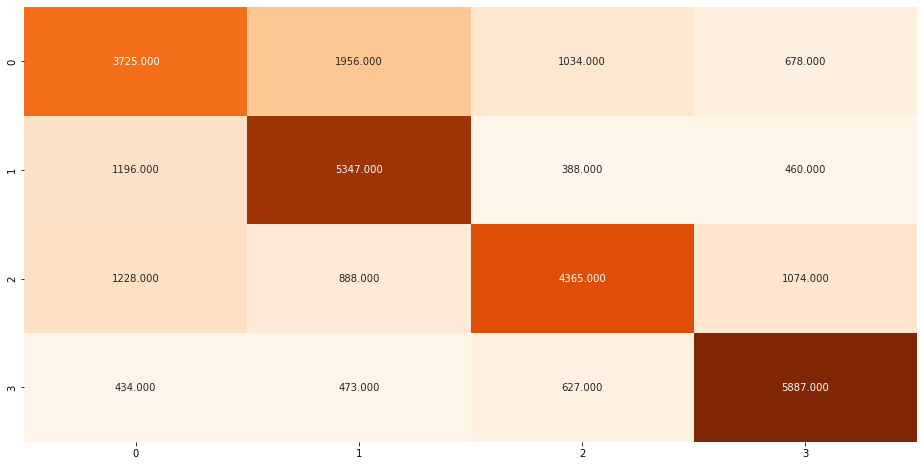

In [29]:
#plotting confusion matrix
plt.figure(figsize=(16,8))
sns.heatmap(cmat1,annot=True,fmt='0.3f',cbar=False,cmap='Oranges');

In [30]:
print(report1)

              precision    recall  f1-score   support

           0       0.57      0.50      0.53      7393
           1       0.62      0.72      0.67      7391
           2       0.68      0.58      0.62      7555
           3       0.73      0.79      0.76      7421

    accuracy                           0.65     29760
   macro avg       0.65      0.65      0.65     29760
weighted avg       0.65      0.65      0.65     29760



In [40]:
model2,y_pred2,f1_score2,accuracy2,precision2,recall2,\
cmat2,report2 = ml_model(DecisionTreeClassifier(),x_train,x_test,y_train,y_test)

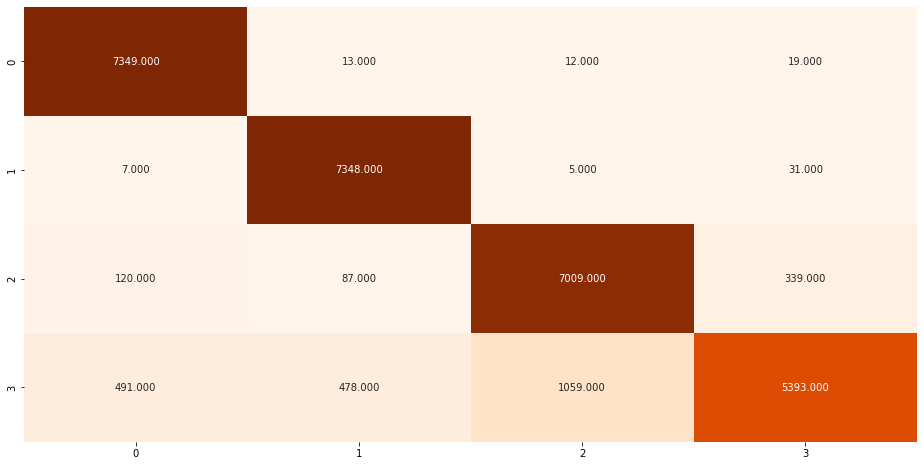

In [41]:
#plotting confusion matrix
plt.figure(figsize=(16,8))
sns.heatmap(cmat2,annot=True,fmt='0.3f',cbar=False,cmap='Oranges');

In [42]:
print(report2)

              precision    recall  f1-score   support

           0       0.92      0.99      0.96      7393
           1       0.93      0.99      0.96      7391
           2       0.87      0.93      0.90      7555
           3       0.93      0.73      0.82      7421

    accuracy                           0.91     29760
   macro avg       0.91      0.91      0.91     29760
weighted avg       0.91      0.91      0.91     29760



In [43]:
model3,y_pred3,f1_score3,accuracy3,precision3,recall3,\
cmat3,report3 = ml_model(RandomForestClassifier(),x_train,x_test,y_train,y_test)

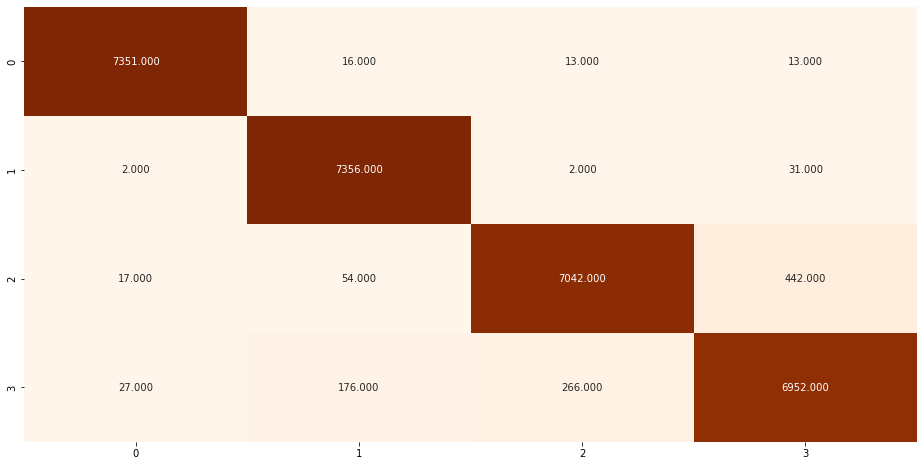

In [44]:
#plotting confusion matrix
plt.figure(figsize=(16,8))
sns.heatmap(cmat3,annot=True,fmt='0.3f',cbar=False,cmap='Oranges');

In [45]:
print(report3)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7393
           1       0.97      1.00      0.98      7391
           2       0.96      0.93      0.95      7555
           3       0.93      0.94      0.94      7421

    accuracy                           0.96     29760
   macro avg       0.96      0.96      0.96     29760
weighted avg       0.96      0.96      0.96     29760



In [46]:
comp1=pd.DataFrame()
comp1['Model']=['Logistic OVR','Decision Tree','Random Forest']
comp1['Accuracy']=[accuracy1,accuracy2,accuracy3]
comp1['Precision']=[precision1,precision2,precision3]
comp1['Recall']=[recall1,recall2,recall3]
comp1['f1-score']=[f1_score1,f1_score2,f1_score3]
comp1

,Model,Accuracy,Precision,Recall,f1-score
0,Logistic OVR,0.649328,0.647862,0.649328,0.645675
1,Decision Tree,0.910585,0.912057,0.910585,0.907247
2,Random Forest,0.964415,0.964384,0.964415,0.964293


In [47]:
instrument_data=pd.read_csv('Instrument_ml_data.csv')
instrument_data.head()

,overall,asin,unixReviewTime,overall_split,date,text,text_token,positive,negative,neutral,compound,vader_sentiment
0,1,B000W89OP2,1427587200,1.0,2015-03-29,got this years ago my only problem with this p...,"['got', 'year', 'ago', 'problem', 'product', '...",0.057,0.320,0.624,-0.9097,Negative
1,5,B010SIRS9E,1509494400,0.0,2017-11-01,the last strings does not really work five stars,"['last', 'string', 'not', 'really', 'work', 'f...",0.000,0.000,1.000,0.0000,Neutral
2,5,B003J7FJ98,1378252800,0.0,2013-09-04,upon receiving the keyboard and tried it perfe...,"['upon', 'receiving', 'keyboard', 'tried', 'pe...",0.293,0.000,0.707,0.8519,Positive
3,1,B00771QSA6,1425513600,1.0,2015-03-05,this is horrible this is a rip off don t buy i...,"['horrible', 'rip', 'buy', 'really', 'recommen...",0.128,0.272,0.600,-0.4815,Conflict
4,5,B0002DUPZU,1488844800,0.0,2017-03-07,great product five stars,"['great', 'product', 'five', 'star']",0.577,0.000,0.423,0.6249,Positive


In [48]:
instrument_data['vader_sentiment'].value_counts()

Positive    23009
Neutral      8404
Negative     4624
Conflict     3963
Name: vader_sentiment, dtype: int64

In [49]:
instrument_data['sentiment_encoded']=label_encoder.fit_transform(instrument_data['vader_sentiment'])

In [50]:
instrument_vector=pd.read_csv("instrument_vectorized.csv")
instrument_vector.head(2)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.034814,0.064835,-0.033559,-0.030410,0.020887,-0.010554,0.003480,0.057081,0.096977,-0.022064,...,0.05604,-0.004366,0.013781,0.041679,0.040939,-0.053549,0.035697,-0.070312,0.016141,0.002079
1,0.031321,-0.031812,0.014827,-0.005265,-0.028531,0.066086,0.000113,0.060869,0.035434,0.008755,...,0.01169,0.013695,-0.044613,0.001436,-0.059198,-0.003137,-0.003530,-0.038577,-0.048716,-0.017238


In [51]:
instrument_vector['sentiment_encoded']=instrument_data['sentiment_encoded']
instrument_vector.head(2)

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,sentiment_encoded
0,0.034814,0.064835,-0.033559,-0.030410,0.020887,-0.010554,0.003480,0.057081,0.096977,-0.022064,...,-0.004366,0.013781,0.041679,0.040939,-0.053549,0.035697,-0.070312,0.016141,0.002079,1
1,0.031321,-0.031812,0.014827,-0.005265,-0.028531,0.066086,0.000113,0.060869,0.035434,0.008755,...,0.013695,-0.044613,0.001436,-0.059198,-0.003137,-0.003530,-0.038577,-0.048716,-0.017238,2


In [52]:
instrument1=instrument_vector.loc[instrument_vector['sentiment_encoded']==0]
instrument1.shape

(3963, 769)

In [53]:
instrument2=instrument_vector.loc[instrument_vector['sentiment_encoded']==1]
instrument2.shape

(4624, 769)

In [54]:
instrument3=instrument_vector.loc[instrument_vector['sentiment_encoded']==2]
instrument3.shape

(8404, 769)

In [55]:
instrument4=instrument_vector.loc[instrument_vector['sentiment_encoded']==3]
instrument4.shape

(23009, 769)

In [56]:
instrument4=music4.sample(n=23000)
instrument4.shape

(23000, 769)

In [57]:
instrument3=music3.sample(n=23000,replace=True)
instrument3.shape

(23000, 769)

In [58]:
instrument2=music2.sample(n=23000,replace=True)
instrument2.shape

(23000, 769)

In [59]:
instrument1=music1.sample(n=23000,replace=True)
instrument1.shape

(23000, 769)

In [60]:
instrument_blc=pd.concat([instrument1,instrument2,instrument3,instrument4])
instrument_blc.shape

(92000, 769)

In [61]:
instrument_blc['sentiment_encoded'].value_counts()

0    23000
1    23000
2    23000
3    23000
Name: sentiment_encoded, dtype: int64

In [63]:
x2=instrument_blc.drop('sentiment_encoded',axis=1)
y2=instrument_blc['sentiment_encoded']

In [65]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size = 0.30, random_state = 0)

In [66]:
input_model=LogisticRegression(max_iter=100)
model4,y_pred4,f1_score4,accuracy4,precision4,recall4,\
cmat4,report4 = one_vs_rest(input_model,x_train2,x_test2,y_train2,y_test2)

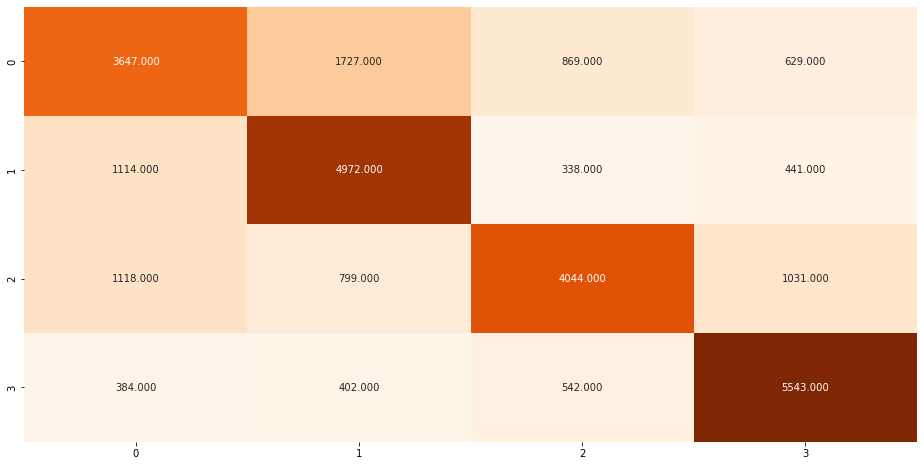

In [67]:
#plotting confusion matrix
plt.figure(figsize=(16,8))
sns.heatmap(cmat4,annot=True,fmt='0.3f',cbar=False,cmap='Oranges');

In [68]:
print(report4)

              precision    recall  f1-score   support

           0       0.58      0.53      0.56      6872
           1       0.63      0.72      0.67      6865
           2       0.70      0.58      0.63      6992
           3       0.73      0.81      0.76      6871

    accuracy                           0.66     27600
   macro avg       0.66      0.66      0.66     27600
weighted avg       0.66      0.66      0.66     27600



In [69]:
model5,y_pred5,f1_score5,accuracy5,precision5,recall5,\
cmat5,report5 = ml_model(DecisionTreeClassifier(),x_train2,x_test2,y_train2,y_test2)

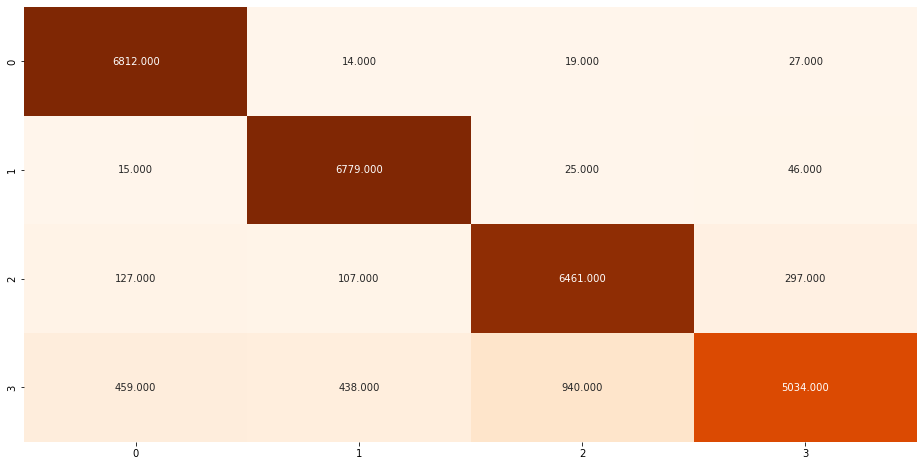

In [70]:
#plotting confusion matrix
plt.figure(figsize=(16,8))
sns.heatmap(cmat5,annot=True,fmt='0.3f',cbar=False,cmap='Oranges');

In [71]:
print(report5)

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      6872
           1       0.92      0.99      0.95      6865
           2       0.87      0.92      0.90      6992
           3       0.93      0.73      0.82      6871

    accuracy                           0.91     27600
   macro avg       0.91      0.91      0.91     27600
weighted avg       0.91      0.91      0.91     27600



In [72]:
model6,y_pred6,f1_score6,accuracy6,precision6,recall6,\
cmat6,report6 = ml_model(RandomForestClassifier(),x_train2,x_test2,y_train2,y_test2)

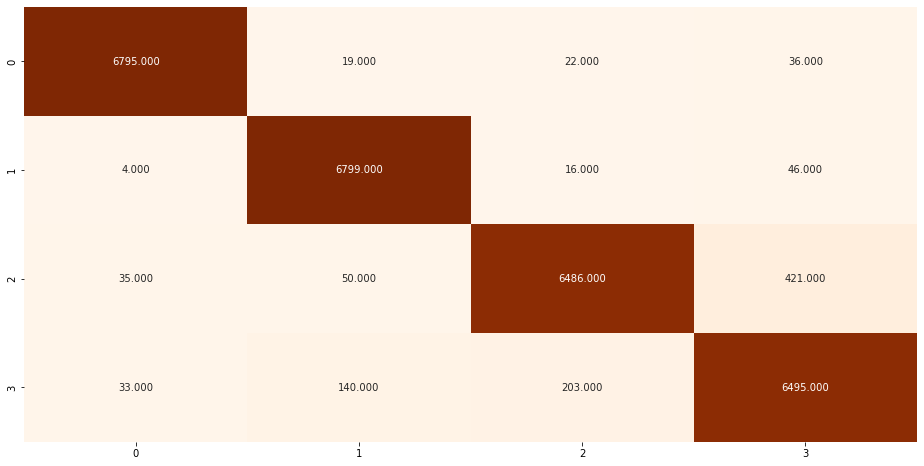

In [73]:
#plotting confusion matrix
plt.figure(figsize=(16,8))
sns.heatmap(cmat6,annot=True,fmt='0.3f',cbar=False,cmap='Oranges');

In [74]:
print(report6)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6872
           1       0.97      0.99      0.98      6865
           2       0.96      0.93      0.95      6992
           3       0.93      0.95      0.94      6871

    accuracy                           0.96     27600
   macro avg       0.96      0.96      0.96     27600
weighted avg       0.96      0.96      0.96     27600



In [75]:
comp2=pd.DataFrame()
comp2['Model']=['Logistic OVR','Decision Tree','Random Forest']
comp2['Accuracy']=[accuracy4,accuracy5,accuracy6]
comp2['Precision']=[precision4,precision5,precision6]
comp2['Recall']=[recall4,recall5,recall6]
comp2['f1-score']=[f1_score4,f1_score5,f1_score6]
comp2

,Model,Accuracy,Precision,Recall,f1-score
0,Logistic OVR,0.659638,0.658902,0.659638,0.656182
1,Decision Tree,0.908913,0.910338,0.908913,0.905839
2,Random Forest,0.962862,0.963002,0.962862,0.962797
